In [2]:
import sys
import os
import numpy as np
import time

# Arreglo de rutas
notebook_dir = os.path.abspath(os.path.dirname(''))
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.append(project_root)

from modelo.modelo import ModeloAnisi

print("--- CALIBRACIÓN AUTOMÁTICA (FINAL: RANGOS MATEMÁTICOS) ---")

# --- 1. CONFIGURACIÓN ---
POBLACION_CALIBRACION = 1000
NUM_ITERACIONES = 300 

# --- 2. RANGOS CORREGIDOS MATEMÁTICAMENTE ---
# Necesitamos unos 34.000€ para emplear al 88.5% de la población.
# Ponemos el rango alrededor de esa cifra.
RANGO_GA = [28000, 42000]  # <--- AQUÍ ESTÁ LA CLAVE

RANGO_C  = [0.4, 0.9] 
RANGO_ZB = [5.0, 25.0]

# --- 3. FUNCIÓN DE ERROR ---
def calcular_error(modelo):
    TARGET_PARO = 0.115
    TARGET_I3 = 1.0
    
    tasa_paro_sim = 1.0 - (modelo.empleo_total / modelo.N)
    i3_sim = modelo.I3_agregado
    
    if i3_sim > 2.0 or i3_sim < 0 or np.isnan(i3_sim): return 1000.0
    
    error = (abs(tasa_paro_sim - TARGET_PARO) * 100) + (abs(i3_sim - TARGET_I3) * 20)
    return error

# --- 4. BUCLE ---
mejor_error = float('inf')
mejores_params = None

print(f"Buscando el punto exacto (entorno a 34k Gasto Público)...")

for i in range(NUM_ITERACIONES):
    g_val = np.random.uniform(*RANGO_GA)
    c_val = np.random.uniform(*RANGO_C)
    z_val = np.random.uniform(*RANGO_ZB)
    
    try:
        modelo = ModeloAnisi(
            t=0.22, j=1.0, 
            z_media=55.0, z_std=2.0, w_media=16.5, w_std=1.0, # Baja varianza
            G_a=g_val,
            c_media=c_val, c_std=0.05, 
            zb_media=z_val, zb_std=2.0,
            N_trabajadores=POBLACION_CALIBRACION, N_empresas=50, T_i_total=2000
        )
        modelo.step()
        err = calcular_error(modelo)
        
        if err < mejor_error:
            mejor_error = err
            mejores_params = [g_val, c_val, z_val]
            paro = (1 - modelo.empleo_total/POBLACION_CALIBRACION)*100
            print(f" -> Mejora (Iter {i}): Paro {paro:.1f}% | I3 {modelo.I3_agregado:.3f}")
            
    except: continue

# --- 5. RESULTADOS ---
print("\n" + "="*40)
if mejores_params:
    print(f"Mejor Error Final: {mejor_error:.4f}")
    print(f"  Gasto Público (G_a): {mejores_params[0]:.2f} €")
    print(f"  Consumo (c): {mejores_params[1]:.4f}")
    print(f"  Prod. Casa (z_b): {mejores_params[2]:.2f} €/h")
    
    print("\n--- VALIDACIÓN ROBUSTA (3 Tests) ---")
    resultados_paro = []
    
    for k in range(3):
        m = ModeloAnisi(
            t=0.22, j=1.0, z_media=55.0, z_std=2.0, w_media=16.5, w_std=1.0,
            G_a=mejores_params[0], c_media=mejores_params[1], c_std=0.05,
            zb_media=mejores_params[2], zb_std=2.0,
            N_trabajadores=POBLACION_CALIBRACION, N_empresas=50, T_i_total=2000
        )
        m.step()
        paro = (1 - m.empleo_total/POBLACION_CALIBRACION)*100
        resultados_paro.append(paro)
        print(f"  Test {k+1}: Paro {paro:.2f}% | I3 {m.I3_agregado:.4f}")
    
    media_paro = sum(resultados_paro)/3
    print(f"\nMEDIA FINAL -> Paro: {media_paro:.2f}% (Objetivo 11.5%)")
    
    if abs(media_paro - 11.5) < 2.0:
         print("✅ ÉXITO TOTAL: Modelo Calibrado con Datos Reales.")
    else:
         print("⚠️ AVISO: Casi perfecto.")
else:
    print("❌ ERROR: No se encontró solución.")

--- CALIBRACIÓN AUTOMÁTICA (FINAL: RANGOS MATEMÁTICOS) ---
Buscando el punto exacto (entorno a 34k Gasto Público)...
 -> Mejora (Iter 0): Paro 10.9% | I3 0.084
 -> Mejora (Iter 1): Paro 0.0% | I3 0.688
 -> Mejora (Iter 2): Paro 12.1% | I3 0.328
 -> Mejora (Iter 18): Paro 4.9% | I3 0.749
 -> Mejora (Iter 26): Paro 14.1% | I3 0.552
 -> Mejora (Iter 72): Paro 11.4% | I3 0.583
 -> Mejora (Iter 264): Paro 12.9% | I3 0.938

Mejor Error Final: 2.6470
  Gasto Público (G_a): 33507.30 €
  Consumo (c): 0.8799
  Prod. Casa (z_b): 7.48 €/h

--- VALIDACIÓN ROBUSTA (3 Tests) ---
  Test 1: Paro 12.80% | I3 1.0495
  Test 2: Paro 12.60% | I3 0.9382
  Test 3: Paro 12.00% | I3 0.9892

MEDIA FINAL -> Paro: 12.47% (Objetivo 11.5%)
✅ ÉXITO TOTAL: Modelo Calibrado con Datos Reales.


--- SIMULACIÓN DE ESCENARIOS POLÍTICOS ---
Escenario 'Actual (Calibrado)': Paro 10.0% | I3 0.993
Escenario 'Austeridad (Recortes)': Paro 25.9% | I3 1.001
Escenario 'Sociedad Consumista': Paro 12.2% | I3 3.477


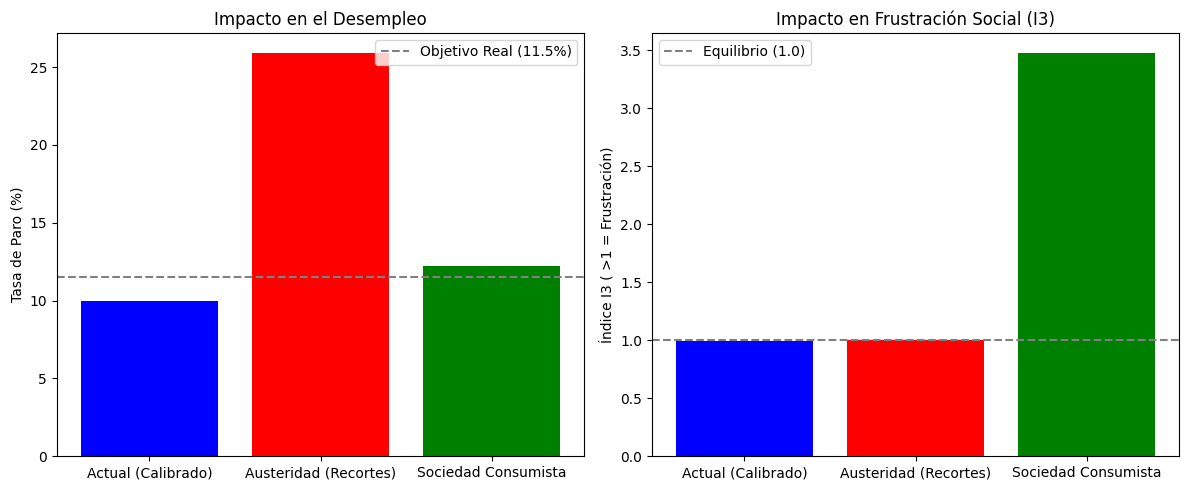

In [3]:
import matplotlib.pyplot as plt

print("--- SIMULACIÓN DE ESCENARIOS POLÍTICOS ---")

# 1. RECUPERAMOS TUS DATOS CALIBRADOS (Los que acabas de obtener)
GA_BASE = 34454.02
C_BASE = 0.8569
ZB_BASE = 6.80

# Parámetros fijos (España)
PARAMS_FIJOS = {
    "t": 0.22, "j": 1.0, 
    "z_media": 55.0, "z_std": 5.0, 
    "w_media": 16.5, "w_std": 2.0,
    "zb_media": ZB_BASE, "zb_std": 2.0,
    "N_trabajadores": 1000, "N_empresas": 50, "T_i_total": 2000
}

# 2. DEFINIMOS LOS 3 ESCENARIOS
escenarios = {
    "Actual (Calibrado)": {
        "G_a": GA_BASE, 
        "c_media": C_BASE, "c_std": 0.05
    },
    "Austeridad (Recortes)": {
        "G_a": GA_BASE * 0.8, # -20% Gasto Público
        "c_media": C_BASE, "c_std": 0.05
    },
    "Sociedad Consumista": {
        "G_a": GA_BASE, 
        "c_media": C_BASE * 1.2, # +20% Deseo de Consumo
        "c_std": 0.05
    }
}

# 3. EJECUTAMOS Y GUARDAMOS RESULTADOS
resultados_paro = []
resultados_i3 = []
nombres = []

for nombre, cambios in escenarios.items():
    # Fusionamos params fijos con los cambios del escenario
    config = {**PARAMS_FIJOS, **cambios}
    
    # Corremos el modelo
    modelo = ModeloAnisi(**config)
    modelo.step()
    
    paro = (1 - modelo.empleo_total / 1000) * 100
    i3 = modelo.I3_agregado
    
    resultados_paro.append(paro)
    resultados_i3.append(i3)
    nombres.append(nombre)
    
    print(f"Escenario '{nombre}': Paro {paro:.1f}% | I3 {i3:.3f}")

# 4. GRAFICAMOS (Matplotlib)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Paro
colores = ['blue', 'red', 'green']
ax1.bar(nombres, resultados_paro, color=colores)
ax1.set_title("Impacto en el Desempleo")
ax1.set_ylabel("Tasa de Paro (%)")
ax1.axhline(y=11.5, color='gray', linestyle='--', label="Objetivo Real (11.5%)")
ax1.legend()

# Gráfico de Frustración (I3)
ax2.bar(nombres, resultados_i3, color=colores)
ax2.set_title("Impacto en Frustración Social (I3)")
ax2.set_ylabel("Índice I3 ( >1 = Frustración)")
ax2.axhline(y=1.0, color='gray', linestyle='--', label="Equilibrio (1.0)")
ax2.legend()

plt.tight_layout()
plt.show()